In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
import os
import sys
import datetime

# Ensure we can import from local modules
sys.path.append(os.getcwd())

# Define Paths
MODEL_DIR = './models'
ANOMALY_PATH = os.path.join(MODEL_DIR, 'anomaly_model.pkl')
FORECAST_PATH = os.path.join(MODEL_DIR, 'forecast_model.pkl')
LSTM_PATH = os.path.join(MODEL_DIR, 'lstm_forecast_model.pth')

print("✅ Libraries loaded. Paths defined.")

✅ Libraries loaded. Paths defined.


In [21]:
# 1. Load Anomaly & RF Models
try:
    anomaly_data = joblib.load(ANOMALY_PATH)
    
    # Handle different save formats
    if isinstance(anomaly_data, dict):
        anomaly_model = anomaly_data['model']
        # Dynamically get features the model expects
        if 'features' in anomaly_data:
            anomaly_features = anomaly_data['features']
        elif hasattr(anomaly_model, 'feature_names_in_'):
            anomaly_features = list(anomaly_model.feature_names_in_)
        else:
            # Fallback for very old models
            anomaly_features = ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']
    else:
        anomaly_model = anomaly_data
        anomaly_features = ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']

    print(f"✅ Anomaly Model loaded.")
    print(f"   Expecting features: {anomaly_features}")
    
    try:
        rf_model = joblib.load(FORECAST_PATH)
        print(f"✅ Random Forest Model loaded.")
    except:
        print("⚠️ Random Forest model not found (Skipping).")
        rf_model = None

except FileNotFoundError:
    print("❌ Scikit-learn models not found. Run 'python ai_engine/trainer.py' first.")
    anomaly_features = []

# 2. Define LSTM Class (3 Inputs: Value, Is_WLAN, Is_Ping)
class LSTMUniversal(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMUniversal, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 3. Load LSTM Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = None

if os.path.exists(LSTM_PATH):
    try:
        lstm_model = LSTMUniversal(input_size=3, output_size=1).to(device)
        lstm_model.load_state_dict(torch.load(LSTM_PATH, map_location=device))
        lstm_model.eval()
        print(f"✅ LSTM model loaded on {device}.")
    except Exception as e:
        print(f"❌ Error loading LSTM: {e}")
else:
    print("⚠️ LSTM model file not found.")

✅ Anomaly Model loaded.
   Expecting features: ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']
✅ Random Forest Model loaded.
✅ LSTM model loaded on cpu.


In [ ]:
# Cell 3: Generate Test Data (Stable LAN vs Unstable WLAN)

def generate_test_data(hours=168): # 1 week
    start = datetime.datetime.now() - datetime.timedelta(hours=hours)
    dates = [start + datetime.timedelta(hours=i) for i in range(hours)]
    df = pd.DataFrame({'timestamp': dates})
    
    # Time Features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    lan_downs = []
    wlan_downs = []
    lan_pings = []
    wlan_pings = []
    
    for i, row in df.iterrows():
        h = row['hour']
        w = row['is_weekend']
        # Usage Pattern
        if w == 0: usage = 0.3 + 0.05 * np.exp(-((h - 14)**2) / 10) 
        else: usage = 0.2 + 0.1 * np.exp(-((h - 20)**2) / 20) 
        
        # LAN Speed: Very Stable (Low noise)
        val_lan = max(0, min(1, usage + np.random.normal(0, 0.02)))
        lan_downs.append(val_lan * 1000)

        # WLAN Speed: Unstable (High noise)
        val_wlan = max(0, min(1, usage * 0.7 + np.random.normal(0, 0.15)))
        wlan_downs.append(val_wlan * 1000)
        
        # LAN Ping: Stable Low
        lan_pings.append(2 + np.random.normal(0, 0.5))
        
        # WLAN Ping: Unstable High
        wlan_pings.append(20 + np.random.normal(0, 15))

    df['lan_down'] = lan_downs
    df['wlan_down'] = wlan_downs
    df['lan_up'] = df['lan_down'] * 0.8
    df['wlan_up'] = df['wlan_down'] * 0.5
    
    df['lan_ping'] = lan_pings
    df['wlan_ping'] = wlan_pings
    
    # Extras
    df['lan_dns'] = 20
    df['wlan_dns'] = 30
    
    return df

df = generate_test_data()
print(f"📊 Generated {len(df)} hours of test data.")
print(f"   Avg LAN Speed: {df['lan_down'].mean():.0f} Mbps (Stable)")
print(f"   Avg WLAN Speed: {df['wlan_down'].mean():.0f} Mbps (Unstable)")
df.head()

📊 Generated 168 hours of test data.
   Avg LAN Speed: 396 Mbps (Stable)
   Avg WLAN Speed: 279 Mbps (Unstable)


,timestamp,hour,day_of_week,is_weekend,lan_down,wlan_down,lan_up,wlan_up,lan_ping,wlan_ping,lan_dns,wlan_dns
0,2026-01-21 11:53:26.486477,11,2,0,547.619639,319.601802,438.095711,159.800901,2.100006,40.776986,20,30
1,2026-01-21 12:53:26.486477,12,2,0,696.242476,635.454076,556.993980,317.727038,1.487996,30.180155,20,30
2,2026-01-21 13:53:26.486477,13,2,0,840.634034,640.428899,672.507227,320.214450,1.344464,24.869891,20,30
3,2026-01-21 14:53:26.486477,14,2,0,894.675883,839.700837,715.740707,419.850418,1.708458,52.950447,20,30
4,2026-01-21 15:53:26.486477,15,2,0,818.243538,813.481754,654.594830,406.740877,2.686908,11.381203,20,30


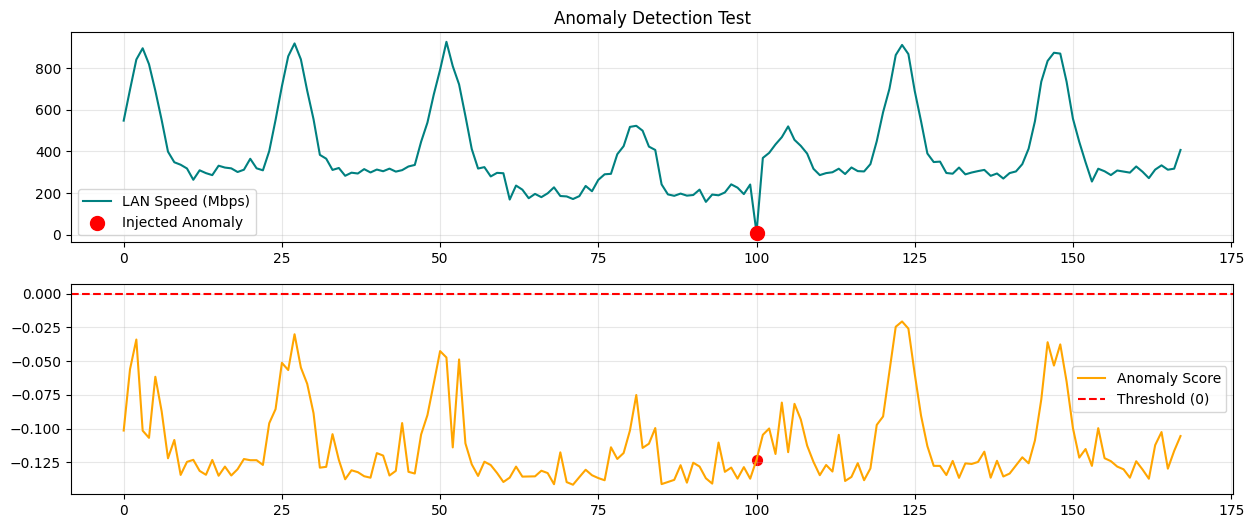

Anomaly Score at index 100: -0.1232 (Should be < 0)


In [38]:
# 1. Create a dataset with anomalies
df_anom = df.copy()

# Inject Anomaly: Traffic drops to near zero, Ping spikes
idx = 100
df_anom.loc[idx, 'lan_down'] = 10 # 10 Mbps instead of ~900
df_anom.loc[idx, 'lan_ping'] = 200 # 200ms

# 2. Normalize Data & Select Features
# Assuming 'default' baseline max is 1000
baseline_max = 1000

# Prepare a normalized copy for prediction
X_anom = df_anom.copy()
X_anom['lan_down'] /= baseline_max
X_anom['lan_up'] /= baseline_max
X_anom['wlan_down'] /= (baseline_max * 0.7) 
X_anom['wlan_up'] /= (baseline_max * 0.35)
X_anom['lan_ping'] /= 100
X_anom['wlan_ping'] /= 100

# *** FIX: Filter columns to match exactly what the model expects ***
# If 'hour' isn't in anomaly_features, it won't be passed.
X_final = X_anom[anomaly_features]

# 3. Predict
preds = anomaly_model.predict(X_final)
scores = anomaly_model.decision_function(X_final)
df_anom['anomaly'] = preds
df_anom['score'] = scores

# 4. Plot
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(df_anom.index, df_anom['lan_down'], label='LAN Speed (Mbps)', color='teal')
plt.scatter(idx, df_anom.loc[idx, 'lan_down'], color='red', s=100, label='Injected Anomaly', zorder=5)
plt.title("Anomaly Detection Test")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df_anom.index, df_anom['score'], label='Anomaly Score', color='orange')
plt.scatter(idx, df_anom.loc[idx, 'score'], color='red', s=50)
plt.axhline(y=0, color='red', linestyle='--', label='Threshold (0)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
print(f"Anomaly Score at index {idx}: {df_anom.loc[idx, 'score']:.4f} (Should be < 0)")

🌲 Generating Random Forest Prediction...
   RF Predictions generated. Mean: 891.98

🧠 Generating LSTM Prediction...
   LSTM Predictions generated. Count: 144

📈 Plotting results...


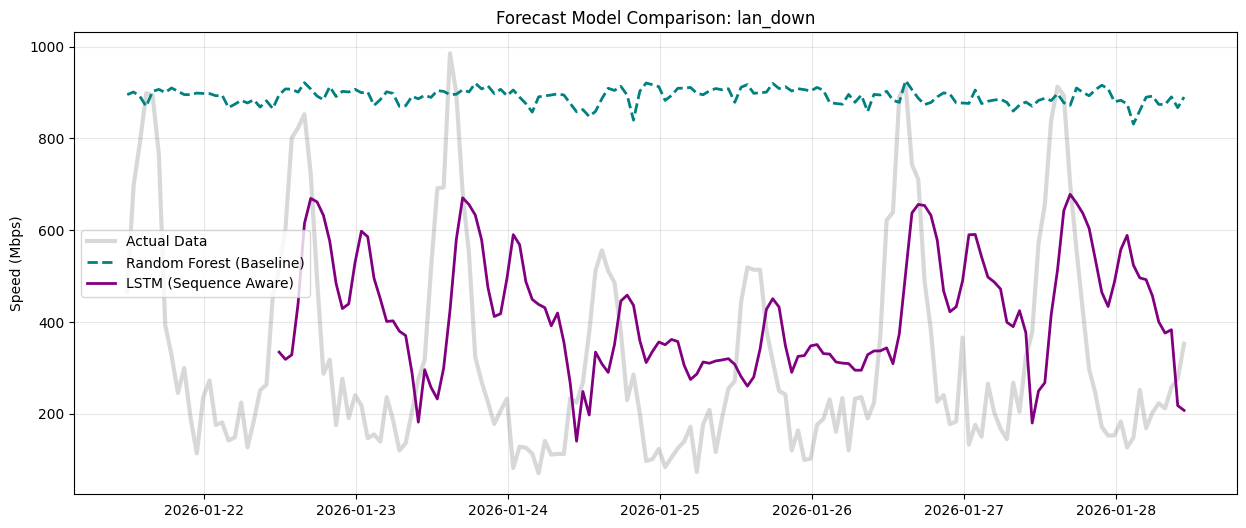

In [36]:
# Cell 5: Visualize Forecasting (Robust Version)

# Configuration
target_col = 'lan_down'
is_wlan = 0.0
is_ping = 0.0
max_val = 1000.0 

# 1. Random Forest Prediction
print("🌲 Generating Random Forest Prediction...")
X_rf = df[['hour', 'day_of_week', 'is_weekend']]
try:
    if 'rf_model' in globals() and rf_model:
        rf_preds_raw = rf_model.predict(X_rf) 
        # Handle Multi-Output (Speed, Ping) vs Single Output
        if rf_preds_raw.ndim > 1 and rf_preds_raw.shape[1] > 1:
            df['rf_pred'] = rf_preds_raw[:, 0] * max_val
        else:
            df['rf_pred'] = rf_preds_raw * max_val
        print(f"   RF Predictions generated. Mean: {df['rf_pred'].mean():.2f}")
    else:
        print("   ⚠️ RF Model not loaded. Skipping RF plot.")
        df['rf_pred'] = np.nan
except Exception as e:
    print(f"   ⚠️ RF Prediction failed: {e}")
    df['rf_pred'] = np.nan

# 2. LSTM Prediction
print("\n🧠 Generating LSTM Prediction...")
seq_length = 24 
lstm_preds = [np.nan] * seq_length # Pad start with NaNs

# Prepare Input Data [Value, Is_WLAN, Is_Ping]
vals_norm = df[target_col].values / max_val
wlan_flags = np.full(len(df), is_wlan)
ping_flags = np.full(len(df), is_ping)
data_matrix = np.column_stack((vals_norm, wlan_flags, ping_flags)).astype(np.float32)

if 'lstm_model' in globals() and lstm_model:
    lstm_model.eval() # Ensure eval mode
    preds_list = []
    try:
        with torch.no_grad():
            for i in range(len(df) - seq_length):
                # Create sequence [1, seq_len, 3]
                seq = data_matrix[i : i+seq_length]
                input_tensor = torch.from_numpy(seq).view(1, seq_length, 3).to(device)
                
                # Predict
                pred = lstm_model(input_tensor)
                val = pred.item()
                preds_list.append(val * max_val)
        
        # Extend dataframe
        lstm_preds.extend(preds_list)
        df['lstm_pred'] = lstm_preds
        print(f"   LSTM Predictions generated. Count: {len(preds_list)}")
    except Exception as e:
        print(f"   ⚠️ LSTM Prediction failed: {e}")
        df['lstm_pred'] = np.nan
else:
    print("   ⚠️ LSTM Model not loaded. Skipping LSTM plot.")
    df['lstm_pred'] = np.nan

# 3. Plotting
print("\n📈 Plotting results...")
plt.figure(figsize=(15, 6))

# Plot Actual
plt.plot(df['timestamp'], df[target_col], label='Actual Data', color='gray', alpha=0.3, linewidth=3)

# Plot RF (if available)
if not df['rf_pred'].isnull().all():
    plt.plot(df['timestamp'], df['rf_pred'], label='Random Forest (Baseline)', color='teal', linestyle='--', linewidth=2)

# Plot LSTM (if available)
if not df['lstm_pred'].isnull().all():
    plt.plot(df['timestamp'], df['lstm_pred'], label='LSTM (Sequence Aware)', color='purple', linewidth=2)

plt.title(f"Forecast Model Comparison: {target_col}")
plt.ylabel("Speed (Mbps)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()